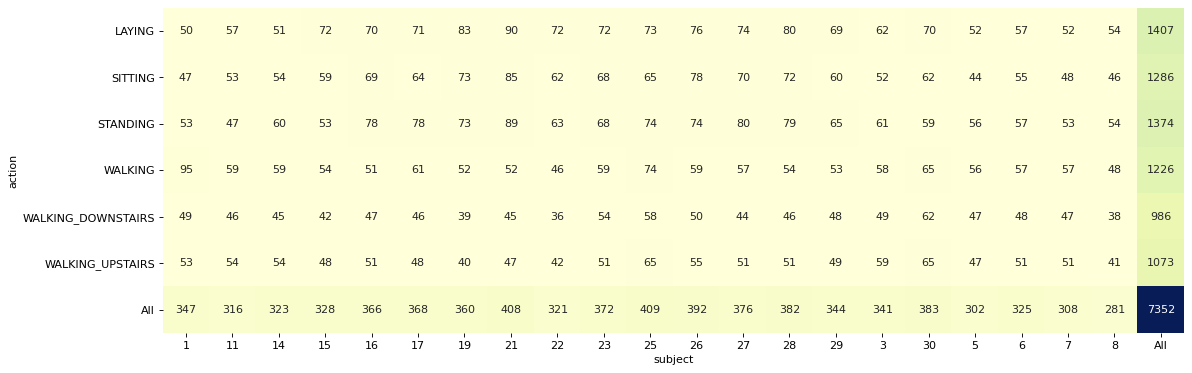

In [92]:
import pandas as pd
#%matplotlib qt5
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
import re
import numpy as np
import glob
import os

'''read datasets from file and prepare vector values'''
def prepareInputData(path, typ=float, fsize=5):
    lines = open(path).read().strip().split("\n")
    # prepare float or input type values from space separated string 
    out = [uniform_filter1d([typ(a) for a in re.split('\s+', lines[i].strip())], size=fsize) for i in range(len(lines))]
    return out



'''return a list of names of datasets and a list of prepared datasets'''
def loadDataVectors(data_dir, file_patt, prepareFn):
    datafiles = glob.glob(os.sep.join((data_dir, file_patt)))
    datafiles.sort()
    # had to use literal separator
    names = [name[name.rindex('\\')+1:name.rindex('.')] for name in datafiles]
    data = []
    for datafile in datafiles:
        data.append(prepareFn(datafile))
    return names, data

import seaborn as sns


'''Show crosstabulation 
    field1 - list of values
    field2 - list of values correlating to field1
    field1_map - if field1 is a list of ints, map is a list of labels with index= field1 - 1
    field2_map - if field2 is a list of ints, map is a list of labels with index= field2 - 1'''
def showCrossTab(field1, field_name1, field2, field_name2, field1_map=None, field2_map=None):
    fig = plt.figure(figsize=(15,10),tight_layout=True, dpi=80)
    if field1_map != None:
        field1 = [field1_map[int(x) - 1] for x in field1]
    if field2_map != None:
        field2 = [y for y in map(lambda x: field2_map[int(x) - 1], field2)]
    
    xtab = pd.DataFrame({field_name1:field1, field_name2:field2})
    sns.heatmap(pd.crosstab(xtab.iloc[:,0], xtab.iloc[:,1], margins=True), square=True,cmap="YlGnBu", annot=True, fmt = "d", cbar=False)

# phone data vectors - each row contains 128 values (2.56 secs at 50Hz)

# feature vectors - 561 values per row
# raw data is loaded in loadOrCreateDTWfeatures only if it hasn't been processed before
test_feat_path = 'UCI HAR Dataset/test'
train_feat_path = 'UCI HAR Dataset/train'
test_featset_names, test_feat = loadDataVectors(test_feat_path, "X*.txt", prepareInputData)
train_featset_names, train_feat = loadDataVectors(train_feat_path, "X*.txt", prepareInputData)
ypath = 'UCI HAR Dataset/test/y_test.txt'
y_test = open(ypath).read().strip().split("\n")
ypath = 'UCI HAR Dataset/train/y_train.txt'
y_train = open(ypath).read().strip().split("\n")

fnamepath = 'UCI HAR Dataset/features.txt'
feat_names = open(fnamepath).read().strip().split("\n")
actpath = 'UCI HAR Dataset/activity_labels.txt'
activities = open(actpath).read().strip().split("\n")
# strip leading number in activity descriptions
activities = [[a for a in re.split('[0-9]\s+', x.strip()) if a!=''][0] for x in activities]


subjpath = 'UCI HAR Dataset/train/subject_train.txt'
subj_train = open(subjpath).read().strip().split("\n")
subjpath = 'UCI HAR Dataset/test/subject_test.txt'
subj_test = open(subjpath).read().strip().split("\n")



# set up a dataframe with the subject and action for crosstabulation

showCrossTab( y_train, "action", subj_train, "subject", field1_map=activities)

In [39]:
import dtw
import random
def createActionList(labelset, x, seed=12):
    random.seed = seed
    typeset = list(set(labelset)) * x
    typeset.sort()
    actions = [labelset.index(a, random.randint(labelset.index(a), len(labelset) - labelset[::-1].index(a) - 1)) for a in typeset]
    return actions

def createDTWmat(querydata, traindata, actionlist, n):
    # data is a tuple of matrices for attribute creation - acc and gyro data
    # for each sample compare with a set of samples of the same data set and store distance
    lens = [len(d) for d in querydata]
    if not lens.count(lens[0]) == len(lens):
        raise ValueError("query datasets must be of same length")
    lens = [len(d) for d in traindata]
    if not lens.count(lens[0]) == len(lens):
        raise ValueError("training datasets must be of same length")
    
    
    distances = []
    for i in range(len(querydata[0])):
        row = []
        # each dataset
        for j in range(len(querydata)):
            query = querydata[j][i]
            row += (findDTWdists(query, traindata[j], actionlist, n))
        distances.append(row)
    return distances

def findDTWdists(query, traindata, actionlist, n):
    #query = data
    # random set of templates?
    #actionlist = createActionList(labelset, x)
    row = []
    dist = 0
    for pos, action in enumerate(actionlist):
        template = traindata[action]
        alignment = dtw.dtw(query, template) #,keep_internals=True)
        
        # take the mean of distances for a single action type and add it to the output list
        if pos !=0 and pos % n == 0:
            row.append(dist/n)
            dist = 0
        dist += alignment.normalizedDistance
    # add last mean distance
    row.append(dist/n)    
    return row


In [41]:
import pickle

def loadOrCreateDTWfeatures(test_rawdata_path=None, train_rawdata_path=None, prepDataFn=None, y_train=None, num_samples_for_DTWtemplate=None):
    # try to read already stored values. If there are no such files then run the feature extraction and store the files
    # TO Do - check input params
    try:
        filehandler = open("actionlist.pkl", 'rb') 
        actionlist = pickle.load(filehandler)
        filehandler = open("train_distances.pkl", 'rb') 
        train_distances = pickle.load(filehandler)
        filehandler = open("test_distances.pkl", 'rb') 
        test_distances = pickle.load(filehandler)


    except FileExistsError:
        _, testdatasets = loadDataVectors(test_rawdata_path, "*.txt", prepDataFn)
        _, traindatasets = loadDataVectors(train_rawdata_path, "*.txt", prepDataFn)


        actionlist = createActionList(y_train, num_samples_for_DTWtemplate)
        #traindatasets = (body_acc_x1_train, body_acc_y1_train, body_acc_z1_train, \
                         #body_gyro_x1_train, body_gyro_y1_train, body_gyro_z1_train, \
                        #total_acc_x1_train, total_acc_y1_train, total_acc_z1_train)
        #testdatasets = (body_acc_x1_test, body_acc_y1_test, body_acc_z1_test, \
                        #body_gyro_x1_test, body_gyro_y1_test, body_gyro_z1_test, \
                       #total_acc_x1_test, total_acc_y1_test, total_acc_z1_test)

        train_distances = createDTWmat(traindatasets, traindatasets, actionlist, num_samples_for_DTWtemplate)
        test_distances = createDTWmat(testdatasets, traindatasets, actionlist, num_samples_for_DTWtemplate)

        filehandler = open(actionlist.pkl, 'xb') 
        actionlist = pickle.dump(filehandler)
        filehandler = open(train_distances.pkl, 'xb') 
        train_distances = pickle.dump(filehandler)
        filehandler = open(test_distances.pkl, 'xb') 
        test_distances = pickle.dump(filehandler)
    return train_distances, test_distances, actionlist
        
# set a value for the number of sample DTW distance values to aggregate
num_samples_for_DTWtemplate = 5
test_rawdata_path = 'UCI HAR Dataset/test/Inertial Signals'
train_rawdata_path = 'UCI HAR Dataset/train/Inertial Signals'
train_distances, test_distances, actionlist = loadOrCreateDTWfeatures(test_rawdata_path, train_rawdata_path, prepareInputData, y_train, num_samples_for_DTWtemplate)      

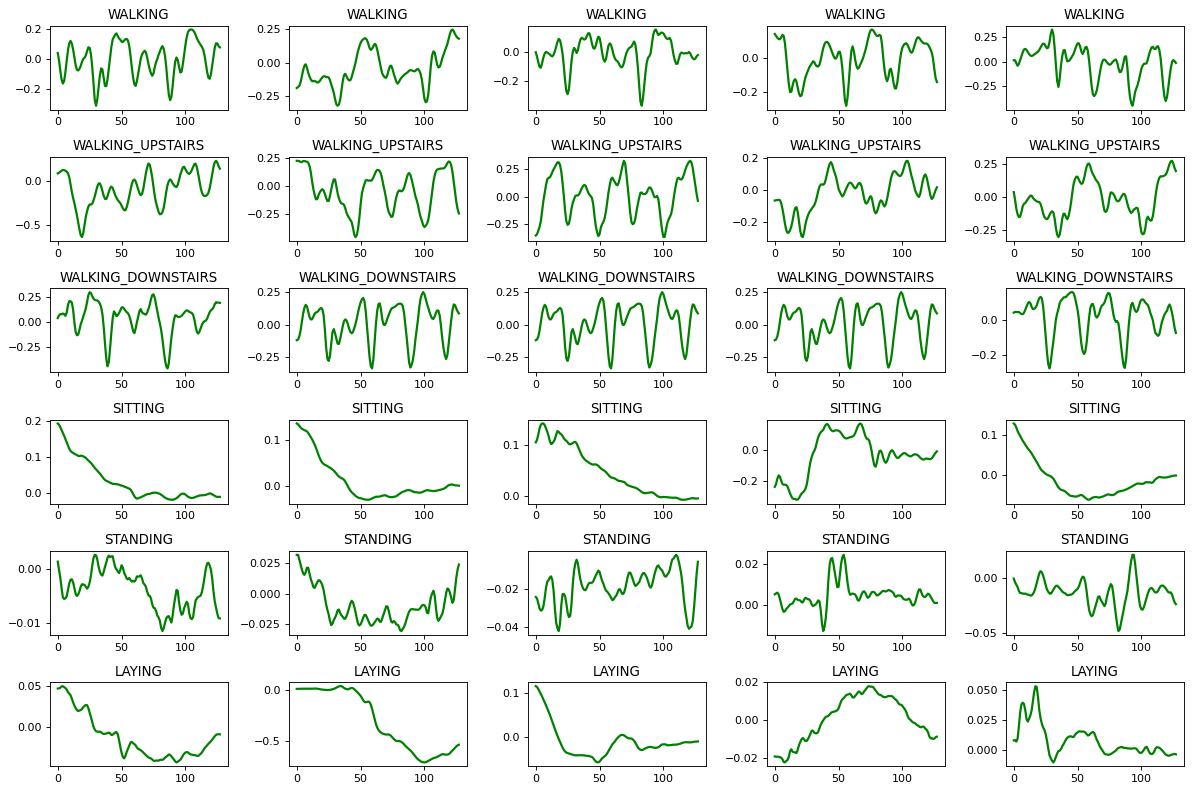

In [93]:

# run plots to show vector similarities across samples
'''show multiplot of actions from the actionlist list of rows for a chosen file
     rawdatafilename should exist in rawdata_path directory'''
def multiPlotVecors(actionlist, activities, y_train, rawdata_path, rawdatafilename, prepDataFn, num_samples=5):
    plt.close()
    fig = plt.figure(figsize=(15,10),tight_layout=True, dpi=80)
    #plt.subplot
    # TO do chexk inputs
    datasetnames, datasets = loadDataVectors(rawdata_path, rawdatafilename, prepDataFn)
    i = datasetnames.index(rawdatafilename[:rawdatafilename.rindex('.')])
    for j in range(num_samples):
        for pos, action in enumerate(actionlist[j::5]):
            #plt.subplot(3,6,pos + 4*int(pos/2) + 1)
            plt.subplot(6,5,pos + 4*int(pos) + j + 1)
            x = datasets[i][action]
            # plot a smoothed curve as well
            #xs = uniform_filter1d(total_acc_z1_train[action], size=5)         
            activity = activities[int(y_train[action]) - 1]
            plt.title(activity)
            plt.plot(x, 'g-', linewidth=2, markersize=8)
            #plt.plot(xs, 'g-', color='red', linewidth=2, markersize=8)
        
    plt.show()

    
train_rawdata_path = 'UCI HAR Dataset/train/Inertial Signals'
rawdatafilename = "body_acc_y_train.txt"
multiPlotVecors(actionlist, activities, y_train, train_rawdata_path, rawdatafilename, prepareInputData, num_samples_for_DTWtemplate)   


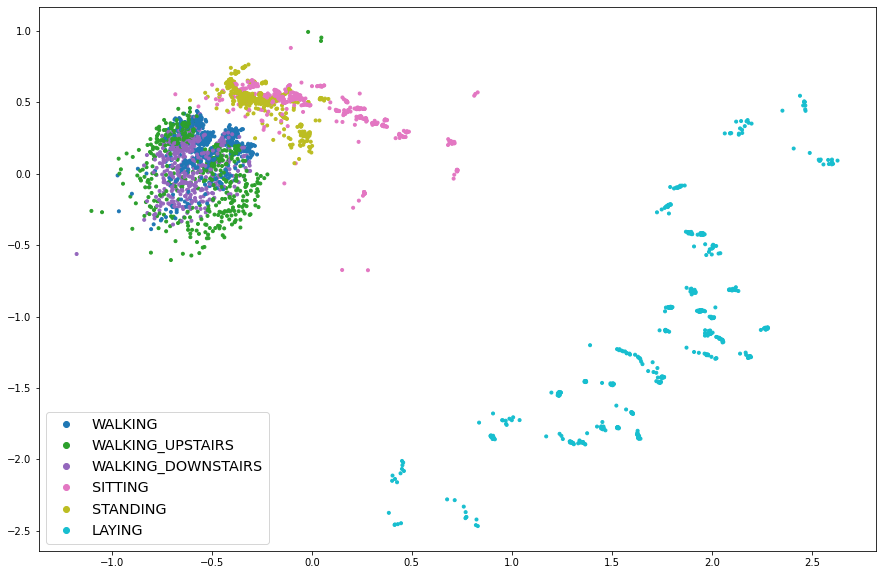

In [94]:
#run MDS plot to show activity clusters 
from sklearn import manifold
from sklearn.metrics import euclidean_distances

'''scatterplot distance matrix with MDS showing different classes in colours
    if classnameset is given for the legend, indices must be the class value -1'''
def showMDSplot(dist_matrix, classes, classnameset={}):
    plt.close()
    similarities = euclidean_distances(dist_matrix)
    mds = manifold.MDS( n_components=2, dissimilarity="precomputed", random_state=6)
    results = mds.fit(similarities)
    coords = results.embedding_
    color = [int(c) -1 for c in classes]
    fig, ax = plt.subplots(figsize=(15,10))
    sc = ax.scatter(coords[:, 0], coords[:, 1], marker = '.', c= color, cmap="tab10")
    handles = sc.legend_elements(prop="colors")[0]
    plt.legend(handles, classnameset, loc='lower left', fontsize="x-large")

showMDSplot(test_distances, y_test, activities)

In [56]:
from sklearn.metrics import roc_auc_score, log_loss, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import sklearn

# FIT models and return predictions for test input

def fitKnn(X_train, X_test, y_train):
    scaler = StandardScaler()
    scaler.fit(X_train)
    scaled_trainfeatures = scaler.transform(X_train)
    scaler.fit(X_test)
    scaled_testfeatures = scaler.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(scaled_trainfeatures, y_train)
    y_pred_knn = knn.predict(scaled_testfeatures)
    return knn, y_pred_knn


def fitDecisionTree(X_train, X_test, y_train):
    model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=100, min_samples_split=100, max_leaf_nodes=8, random_state=2)
    model.fit(X_train, y_train)
    y_pred_dt = model.predict(X_test)

    return model, y_pred_dt

def fitLogisticRegression(X_train, X_test, y_train):
    l = LogisticRegression(multi_class='ovr', max_iter=400)
    # scale the data for regression for feature importance values
    scaler = StandardScaler()
    X_train_scale = scaler.fit_transform(X_train)
    l.fit(X_train_scale, y_train)
    y_pred_lr = l.predict(scaler.transform(X_test))
    return l, y_pred_lr
    
def fitRandomForest(X_train, X_test, y_train):
    r = RandomForestClassifier(n_estimators=100,max_depth=5, max_features=17, random_state=2)
    r.fit(X_train,y_train)
    y_pred_rf = r.predict(X_test)
    return r, y_pred_rf

def fitSVM(X_train, X_test, y_train):
    svc = sklearn.svm.LinearSVC() 
    svc.fit(X_train, y_train)
    y_pred_svm = svc.predict(X_test)
    return svc, y_pred_svm

In [97]:
from keras.models import Sequential
from keras.layers import Dense 
#from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from keras.utils import to_categorical

    

def constructNNmodel(input_len):
    nnmodel = Sequential()
    nnmodel.add(Dense(64, input_dim=input_len , activation='relu'))
    nnmodel.add(Dense(64, activation='relu'))
    nnmodel.add(Dense(6, activation='sigmoid'))
    nnmodel.compile(optimizer = Adam(lr = 0.0005),loss='categorical_crossentropy', metrics=['accuracy'])
    print(nnmodel.summary())
    return nnmodel
    
def fitNN(x_train, x_test, y_train):
    # one hot classes
    by_train = to_categorical(pd.DataFrame([int(y) -1 for y in y_train]) , num_classes=6, dtype=int)
    nnmodel = constructNNmodel(len(x_test[0]))
    history = nnmodel.fit(np.array(x_train), by_train , epochs=15 , batch_size = 256 ) 
    y_pred_nn = nnmodel.predict(x_test)
    # return one hot to class string
    y_pred_nn = [str(y+1) for y in np.argmax(y_pred_nn,axis = 1)]
    return nnmodel, y_pred_nn
  
    
    

In [98]:
knn, y_pred_knn = fitKnn(train_distances, test_distances, y_train)
dtmodel,y_pred_dt = fitDecisionTree(train_distances, test_distances, y_train)
lr, y_pred_lr = fitLogisticRegression(train_distances, test_distances, y_train)
rf, y_pred_rf = fitRandomForest(train_distances, test_distances, y_train)
svc, y_pred_svm = fitSVM(train_distances, test_distances, y_train)
nnmodel, y_pred_nn = fitNN(train_distances, test_distances, y_train)




Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                3520      
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 6)                 390       
Total params: 8,070
Trainable params: 8,070
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
29/29 [==============================] - 0s 2ms/step - loss: 1.7747 - accuracy: 0.1663
Epoch 2/15
29/29 [==============================] - 0s 2ms/step - loss: 1.5318 - accuracy: 0.5197
Epoch 3/15
29/29 [==============================] - 0s 2ms/step - loss: 1.2944 - accuracy: 0.5269
Epoch 4/15
29/29 [==============================] - 0s 2ms/step - loss: 1.0872 - ac

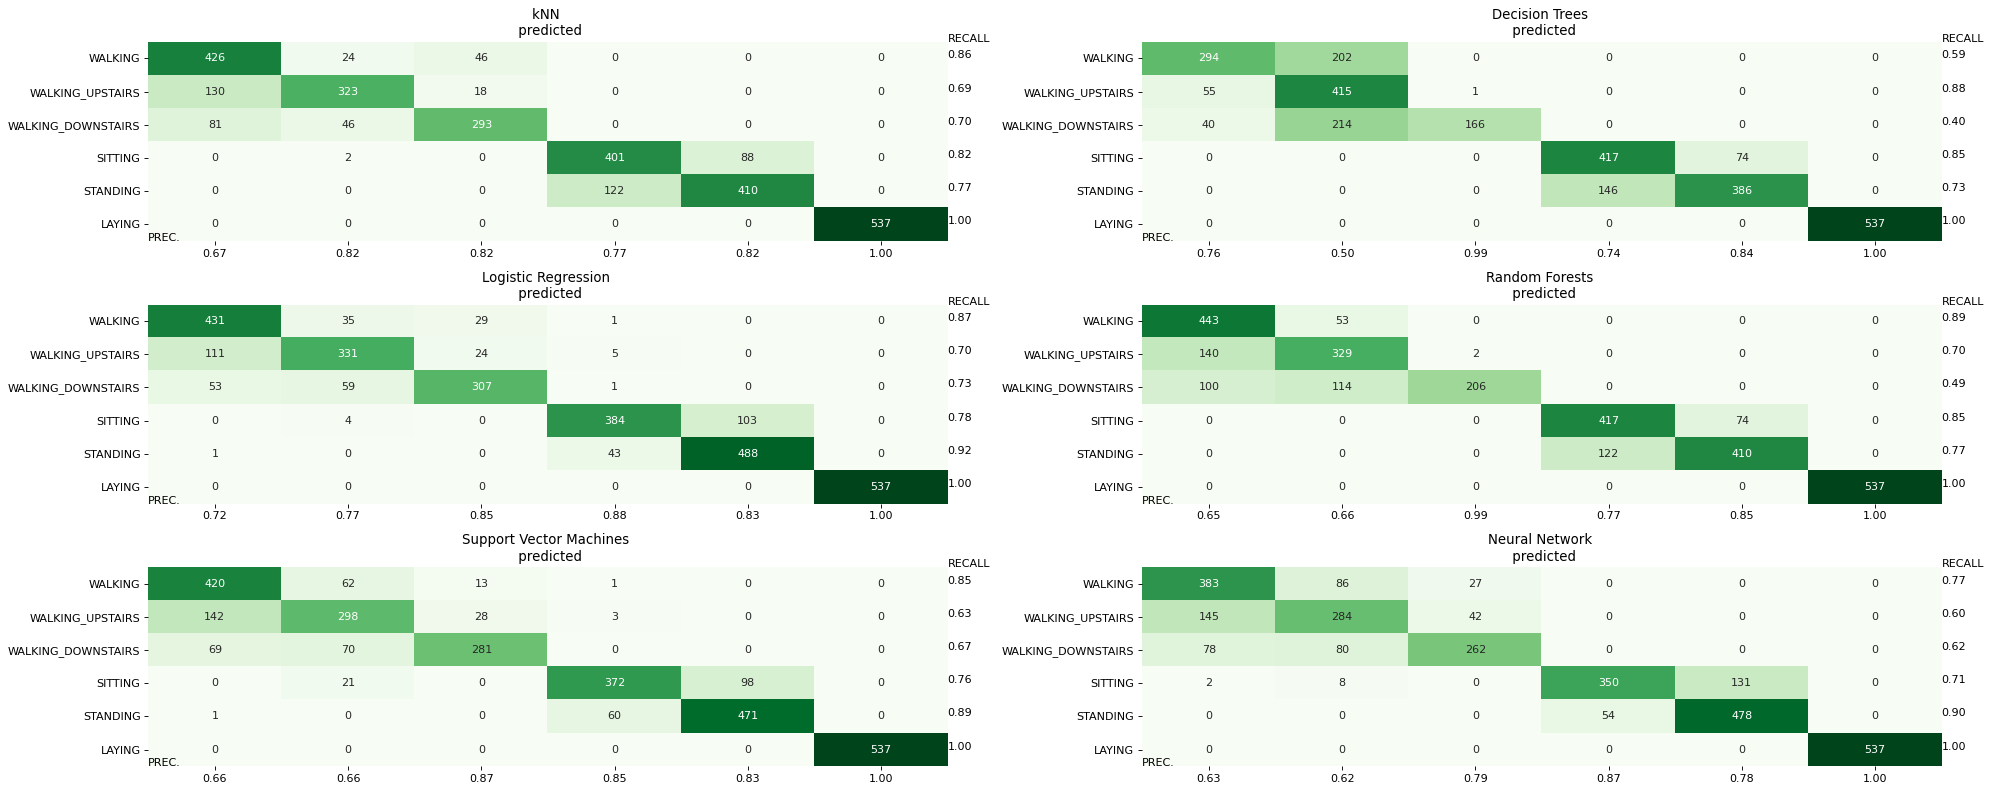

In [95]:
import seaborn as sns
fig = plt.figure(figsize=(25,10),tight_layout=True, dpi=80)

def plotconfusion(ax, CM, y_test, y_pred, activities):
    recall = sklearn.metrics.recall_score(y_test, y_pred, average=None)
    precision = sklearn.metrics.precision_score(y_test, y_pred, average=None)

    ax.annotate("RECALL",(6.0,0.0))
    ax.annotate("PREC.",(0.0,6.0))
    for x in range(len(recall)):  
        ax.annotate("{:3.2f}".format(recall[x]),(6.0,0.5 + x))
    precisionvals = ["{:3.2f}".format(precision[x]) for x in range(len(precision))]
    sns.heatmap(CM.data,cmap='Greens',annot=CM, fmt='',cbar=False,xticklabels=precisionvals, yticklabels=activities)


def tabulateConfusion(y_test, y_pred_dict, activities):
    CMknn = confusion_matrix(y_test, y_pred_dict["y_pred_knn"])
    CMdt = confusion_matrix(y_test, y_pred_dict["y_pred_dt"])
    CMlr = confusion_matrix(y_test, y_pred_dict["y_pred_lr"])
    CMrf = confusion_matrix(y_test, y_pred_dict["y_pred_rf"])
    CMsvm = confusion_matrix(y_test, y_pred_dict["y_pred_svm"])
    CMnn = confusion_matrix(y_test, y_pred_dict["y_pred_nn"])

        
    ax = plt.subplot(3,2,1)
    ax.set_title("kNN \n predicted")
    plotconfusion(ax, CMknn, y_test, y_pred_knn, activities)

    ax = plt.subplot(3,2,2)
    ax.set_title("Decision Trees \n predicted")
    plotconfusion(ax, CMdt, y_test, y_pred_dt, activities)
    ax = plt.subplot(3,2,3)
    ax.set_title("Logistic Regression \n predicted")
    plotconfusion(ax, CMlr, y_test, y_pred_lr, activities)
    ax = plt.subplot(3,2,4)
    ax.set_title("Random Forests \n predicted")
    plotconfusion(ax, CMrf, y_test, y_pred_rf, activities)
    ax = plt.subplot(3,2,5)
    ax.set_title("Support Vector Machines \n predicted")
    plotconfusion(ax, CMsvm, y_test, y_pred_svm, activities)
    ax = plt.subplot(3,2,6)
    ax.set_title("Neural Network \n predicted")
    plotconfusion(ax, CMnn, y_test, y_pred_nn, activities)
    plt.show()

y_pred_dict = {"y_pred_knn":y_pred_knn, "y_pred_dt":y_pred_dt, "y_pred_lr":y_pred_lr, \
               "y_pred_rf":y_pred_rf, "y_pred_svm":y_pred_svm, "y_pred_nn":y_pred_nn}
tabulateConfusion(y_test, y_pred_dict, activities)

In [96]:
import sklearn
from sklearn.metrics import confusion_matrix

#print(CMlr)
rep = sklearn.metrics.classification_report(y_test, y_pred_lr, target_names=activities)
print(rep)

                    precision    recall  f1-score   support

           WALKING       0.72      0.87      0.79       496
  WALKING_UPSTAIRS       0.77      0.70      0.74       471
WALKING_DOWNSTAIRS       0.85      0.73      0.79       420
           SITTING       0.88      0.78      0.83       491
          STANDING       0.83      0.92      0.87       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.84      2947
         macro avg       0.84      0.83      0.84      2947
      weighted avg       0.85      0.84      0.84      2947

